# CDR Experiments via Pymagicc
##### CC-BY 4.0 2020 @safiume
#### https://github.com/hsbay/cdrmex

In [1]:
# NBVAL_IGNORE_OUTPUT
import sys, re
from os import listdir
from os.path import join, dirname
from pprint import pprint
import expectexception
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
import f90nml

In [2]:
#Disable warning supression if running locally
import warnings
warnings.simplefilter("ignore", category=Warning, lineno=0, append=False)

In [3]:
import pymagicc
from pymagicc import MAGICC6
from pymagicc.io import MAGICCData, read_cfg_file, NoReaderWriterError
from pymagicc.scenarios import ( rcp26, rcp45, zero_emissions )
from scmdata import run_append
print(pymagicc.__version__)
print(sys.version)
rcp26.__class__.__bases__

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


2.0.0rc8+19.g7aade1e.dirty
3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


(scmdata.run.ScmRun,)

In [4]:
## List of experiments in declines
declines = ["emax", "lmax", "emin", "lmin"]
SCEN_DIR = "SCEN"
MAGICC6_DIR = join("..", "CDRRUN")

# Start MAGICC at 1720 or before
# The baseline for 0 °C will be recalculated based the mean
# temp for 1720-1800.
## Start of MAGICC settings
magcfg = { "startyear" : 1710,
          "endyear" : 2501,
          "core_climatesensitivity" : 2.6,             #BERN
#          "co2_tempfeedback_yrstart" : 2005,
#          "co2_fertilization_yrstart" : 2005,
          "co2_switchfromconc2emis_year" : 2010,
          "rf_mhalo_constantafteryr" : 2250,
          "rf_fgas_constantafteryr" : 2250,
          "out_forcing" : 1,
          "out_emissions" : 1,
          "out_concentrations" : 1 }
### End MAGICC Settings

Import IMAGE-SSP1-1.9 from manually imported SCEN built from 
"IMAGE 3.0.1","SSP1-19","World","Diagnostics|MAGICC6|Harmonized Input|*

© IAMC 1.5°C Scenario Explorer hosted by IIASA https://data.ene.iiasa.ac.at/iamc-1.5c-explorer

There are some artifacts in the dataset and subsequent graphs as the download was missing the full fgasses and halo gasses.

In [5]:
# Reassign startyear to include the year 1720.
graphstart = magcfg['startyear']
if magcfg['startyear'] > 1720:
    magcfg['startyear'] = 1720

## load experiments scen file data
for n, name in enumerate (declines):
    declinefile = join(SCEN_DIR, "ONC" + name + ".SCEN")
    declines[n] = MAGICCData(declinefile,
                             columns={"model": ["CDRex"], "scenario": [name]})

img119 = MAGICCData(join(SCEN_DIR, 'imgs119.SCEN'), 
                    columns={"model": ["IMAGE"], "scenario": ['SSP119']}, inplace=True)
declines.append(img119)

# Copy lmin data into new experiment
CCCx2050 = declines[3]
CCC_df = CCCx2050.timeseries()
CCC_df = CCC_df.rename(index={"lmin":"CCCx2050"})

In [6]:
declines[2].timeseries().head(3)

time                                                                                             2005-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial       8.030   
                                                     Emissions|CO2|MAGICC AFOLU                       1.180   
                                         Mt CH4 / yr Emissions|CH4                                  315.903   

time                                                                                             2010-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.1209   
                                                     Emissions|CO2|MAGICC AFOLU                      1.3732   
                                         Mt CH4 / yr Emissions|CH4                                 332.0000   

time                                                                                             2011-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.4954   
                                                     Emissions|CO2|MAGICC AFOLU                      1.3204   
                                         Mt CH4 / yr Emissions|CH4                                 335.0000   

time                                                                                             2012-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.6670   
                                                     Emissions|CO2|MAGICC AFOLU                      1.3786   
                                         Mt CH4 / yr Emissions|CH4                                 338.0000   

time                                                                                             2013-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.7651   
                                                     Emissions|CO2|MAGICC AFOLU                      1.4088   
                                         Mt CH4 / yr Emissions|CH4                                 341.0000   

time                                                                                             2014-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.8475   
                                                     Emissions|CO2|MAGICC AFOLU                      1.3788   
                                         Mt CH4 / yr Emissions|CH4                                 344.0000   

time                                                                                             2015-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  emin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial      9.8306   
                                                     Emissions|CO2|MAGICC AFOLU                      1.5191   
                                         Mt CH4 / yr Emissions|CH4                                 347.0000   

time                                                                                             2016-01-01 

In [7]:
def interpt(start,end,length):
    start = float(start)
    end = float(end)
    length = int(length)  
    array = np.linspace(0, length, length+1)
    array = np.interp(array,[0,length],[start,end])
    return array

In [8]:
# Calculate how much carbon to remove to achieve 300 ppm at 2050
CRsyr = 2021
Bkyr = 2050
# CO₂ gas is in GtC
AnthroC = 462.44
LuC = 164.90
CCCxFF = 187
CCCxLuC = 103
pkAC = 10.917

In [9]:
ki_mo_ghgs_F = [ 'HFC134a', 'HFC245fa', 'HFC227ea', 'HFC4310', 'HFC32', 'HFC125', 'HFC143a', 'HFC23' ]
#Inc Kigali/MontrealP GhG years
timepts = {
    'kigyr1' : [2019, .998],
    'pkyr' : [(CRsyr - 1), 1],
    'kigyr2' : [2024, .95], 
    'kigyr3' : [2025, .65],
    'kigyr4' : [2029, .30],
    'kigyr5' : [2034, .20],
    'sf6eu' : [2030, .30],
    'kigyr6' : [2036, .15],
    'edyr' : [2100, 0]
}
timepts.update({ 'CRsyr': [CRsyr, .97 ], 'Bkyr': [Bkyr, 0] })
timepts = pd.DataFrame(timepts,['year','NtZeroPcnt']).T
timepts = timepts.sort_values(by='year')

#Net Zero Dates - zero emissions for non CO2 gasses
n0dates = [2032, 2100]

# harmonize to GCB(2020) FF+luc Ghg
# https://doi.org/10.18160/GCP-2020
# [2010-2020]
FF=[9.04, 9.34, 9.49, 9.55, 9.62, 9.61, 9.61, 9.74, 9.94, 9.95, 9.3]
# 2005, [2010-2020]
luc=[1.42, 1.46, 1.38, 1.49, 1.53, 1.65, 1.70, 1.56, 1.52, 1.55, 1.80, 1.6]

In [10]:
ems_ff = 'Emissions|CO2|MAGICC Fossil and Industrial'
ems_luc = 'Emissions|CO2|MAGICC AFOLU'
methane = 'Emissions|CH4'
emsf = ('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr', ems_ff)
emsluc = ('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr', ems_luc)

In [11]:
def dtspn(emm,dates,vals,df):
    if type(emm) == str:
        ndf = df.xs(emm, level = 'variable', drop_level = False)
    else :
        ndf = df.loc[:,:,:,:,:,:,emm]
    row = ndf.index.values
    ndf.at[row, datetime(dates[0],1,1) : datetime(dates[1],1,1)] = vals
    df.loc[ndf.index.values] = ndf 
    return df

def kigali(ki_ghgs,df):
    kgfs = []
    for kgs in ki_ghgs:
        kgs = ('Emissions|') + kgs
        kgfs.append(kgs)
    ndf = df.loc[:,:,:,:,:,:,kgfs]
    row = ndf.index.values
    for i, tmpt in enumerate(timepts['year']):
        if tmpt < (timepts['year'].max()):
            tmpt = int(tmpt)
            nxtyr = int(timepts.iloc[[i+1],0].item())
            prevrate = timepts.iloc[[i],1].item()
            rate = ndf.at[row[(1-i)],datetime(tmpt,1,1,0)] * prevrate
            ndf.at[row, datetime(tmpt,1,1,0):datetime(nxtyr,1,1,0)] = rate
    df.loc[ndf.index.values] = ndf
    return df

def decline(ems, dates, xrate, df):
    ndf = df.xs(ems, level = 'variable', drop_level = False)
    row = ndf.index.values
    slc = ndf.loc[row, datetime(dates[0],1,1):datetime(dates[1],1,1)]
    slc.apply(lambda x: x * xrate)
    df.loc[ndf.index.values] = ndf
    return df


df = CCC_df.copy()

dates = [2010, 2020]
df = dtspn( ems_ff, dates, FF, df)
dates = [2005, 2020]
df = dtspn( ems_luc, dates, luc, df)
#df = kigali(ki_mo_ghgs_F, df)
xrate = -0.336
dates = [2020, 2049]
df = decline(methane, dates, xrate, df)
# strip CO₂ FF, Luc, NH4 from index.values
net0 = df.index.get_level_values(6)[2:10]
net0 = net0.append(df.index.get_level_values(6)[11:23])
val = (0)
df = dtspn( net0, n0dates, val, df)

CCC_df = df.copy()
#df #print copy for diags

In [12]:
LuC_2050 = LuC - CCCxLuC
landsnk_yrly = LuC_2050/((Bkyr) - CRsyr)
landsnc_remainingYr = CCCxLuC/(2100 - Bkyr)

AC_2050 = AnthroC - CCCxFF
Peak_to_bk_yr = AC_2050/((Bkyr) - CRsyr)
Remaining_per_yr = CCCxFF/(2100 - Bkyr)

# Set removal according to forumlas in previous cell
CCC_df.loc[emsluc, datetime(2025,1,1) : datetime(2049,1,1)] = -landsnk_yrly
CCC_df.loc[emsluc, datetime(2050,1,1) : datetime(2099,1,1)] = -landsnc_remainingYr
CCC_df.loc[emsf, datetime(2025,1,1) : datetime(2049,1,1)] = -Peak_to_bk_yr
CCC_df.loc[emsf, datetime(2050,1,1) : datetime(2099,1,1)] = -Remaining_per_yr

In [13]:
# Zero out data past 2100 
CCC_df.loc[emsf, datetime(2100,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_df.loc[emsluc, datetime(2100,1,1,0) : datetime(2150,1,1,0)] = 0

In [14]:
# Rewrite CCCx2050 from timeseries and wrap in MAGICCData
CCCx2050 = MAGICCData(CCC_df.copy())
#CCC_df.to_csv('CCCx2050.csv')

CCC_flat = CCC_df.copy()
CCC_flat.loc[emsf, datetime(2051,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_flat.loc[emsluc, datetime(2051,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_flat = CCC_flat.rename(index={"CCCx2050":"CCCxflat"})
CCCxflat = MAGICCData(CCC_flat.copy())

In [15]:
print("Diagnostic Output")
print(CCC_df.head(2).iloc[:,[10]])
print(CCC_df.head(2).iloc[:,[32]])
print(CCC_df.head(2).iloc[:,[42]])
CCCx2050.timeseries().head(3)

Diagnostic Output
time                                                                                           2019-01-01
climate_model model region scenario todo unit      variable                                              
unspecified   CDRex World  CCCx2050 SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial        9.95
                                                   Emissions|CO2|MAGICC AFOLU                        1.80
time                                                                                           2041-01-01
climate_model model region scenario todo unit      variable                                              
unspecified   CDRex World  CCCx2050 SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial   -9.497931
                                                   Emissions|CO2|MAGICC AFOLU                   -2.134483
time                                                                                           2051-01-01
climate_model model region s

time                                                                                             2005-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial       8.030   
                                                     Emissions|CO2|MAGICC AFOLU                       1.420   
                                         Mt CH4 / yr Emissions|CH4                                  315.903   

time                                                                                             2010-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial        9.04   
                                                     Emissions|CO2|MAGICC AFOLU                        1.46   
                                         Mt CH4 / yr Emissions|CH4                                   332.00   

time                                                                                             2011-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial        9.34   
                                                     Emissions|CO2|MAGICC AFOLU                        1.38   
                                         Mt CH4 / yr Emissions|CH4                                   335.00   

time                                                                                             2012-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial        9.49   
                                                     Emissions|CO2|MAGICC AFOLU                        1.49   
                                         Mt CH4 / yr Emissions|CH4                                   338.00   

time                                                                                             2013-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial        9.55   
                                                     Emissions|CO2|MAGICC AFOLU                        1.53   
                                         Mt CH4 / yr Emissions|CH4                                   341.00   

time                                                                                             2014-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial        9.62   
                                                     Emissions|CO2|MAGICC AFOLU                        1.65   
                                         Mt CH4 / yr Emissions|CH4                                   344.00   

time                                                                                             2015-01-01  \
climate_model model region scenario todo unit        variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial        9.61   
                                                     Emissions|CO2|MAGICC AFOLU                        1.70   
                                         Mt CH4 / yr Emissions|CH4                                   347.00   

time                                                                                             2016-01-01 

In [16]:
# Force sample rcp26 to end CR at 2101
rcp26df = rcp26.timeseries()
rcp26df = rcp26df.rename(columns={datetime(2125,1,1,0):datetime(2101,1,1,0)})
rcp26df.loc[:, datetime(2101,1,1,0) : datetime(2500,1,1,0)] = 0
rcp26 = MAGICCData(rcp26df.copy())

# Scenarios

The five RCP scenarios and experimental declines are loaded as DataFrames in pyhector. They contain the following emissions:

In [ ]:
rcp26.filter(region='World').timeseries().loc[:,datetime(2090,1,1,0):datetime(2101,1,1,0)].tail(4)

In [ ]:
rcp26.head(2)

They are split up in regions:

In [ ]:
rcp26["region"].unique()

They have the following units:

In [ ]:
#pymagicc.units
#rcps[["variable", "unit"]].drop_duplicates()
rcp26["unit"].head()

In [ ]:
categories_to_plot = rcp26["variable"].drop_duplicates().tolist()

for g in rcp26.filter(
    variable=categories_to_plot,
    year=range(2000, 2150)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="region").set_title(g.get_unique_meta("variable", True))

In [ ]:
categories_to_plot = rcp26["variable"].drop_duplicates().tolist()
for g in declines[3].filter(
    region="World",
    variable=categories_to_plot,
    year=range(2000, 2150)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="scenario").set_title(g.get_unique_meta("variable", True))

In [ ]:
categories_to_plot = CCCx2050["variable"].drop_duplicates().tolist()

for g in CCCx2050.filter(
    variable=categories_to_plot,
    year=range(2000, 2101)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="region").set_title(g.get_unique_meta("variable", True))

# Fossil fuel emissions for the five RCP scenarios and Experimental Declines.

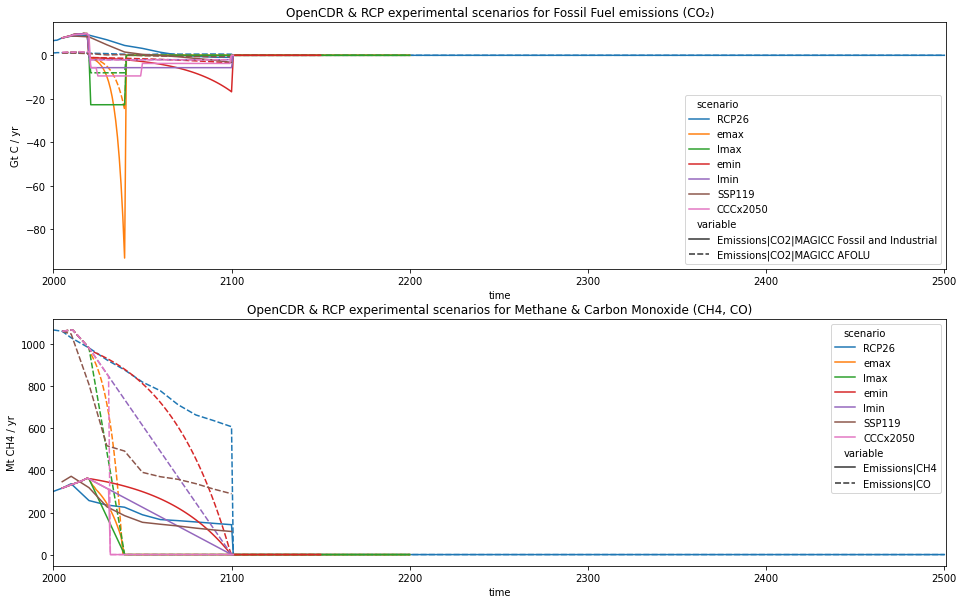

In [21]:
x = (datetime(2000, 1, 1), datetime(magcfg["endyear"], 1, 1))
pret="OpenCDR & RCP experimental scenarios for "
gtgvar = "*CO2|MAGICC Fossil and Industrial", "*CO2|MAGICC AFOLU*"
mtgvar = "*Emissions|CH4", "*Emissions|CO"
list = [gtgvar,mtgvar]
title = [pret + "Fossil Fuel emissions (CO₂)", 
         pret + "Methane & Carbon Monoxide (CH4, CO)"]
declines.append(CCCx2050)
mdata = MAGICCData(rcp26)
for scen in declines:
    mdata = mdata.append(scen)
fig, axes = plt.subplots(2,1, figsize = (16, 10))
for n,var in enumerate(list):
    varun = var[(n-1)]
    test = mdata.filter(region="World", variable=var).lineplot(hue="scenario", style="variable", ax=axes[n])
    ylab = declines[0].filter(region="World", variable=varun)["unit"].iloc[[0]].all()
    if ylab == 'K':
        ylab = '°C'
    axes[n].set_ylabel(ylab)
    axes[n].set_title(title[n])
    axes[n].set_xlim(x)

## Running MAGICC

A single `pymagicc` run doesn't take long and returns a Pandas Dict.
(If not on Windows, the very first run might be slower due to setting up Wine.)

In [22]:
%time results = pymagicc.run(rcp26)
results = ""
%time results = pymagicc.run(declines[0].filter(), **magcfg)
results = ""
%time results = pymagicc.run(rcp26, **magcfg)
slice = results.filter(region="World",variable="Radiative Forcing")["unit"].head(3)

CPU times: user 857 ms, sys: 94.3 ms, total: 951 ms
Wall time: 7.17 s
CPU times: user 3.57 s, sys: 189 ms, total: 3.76 s
Wall time: 9.5 s
CPU times: user 3.17 s, sys: 185 ms, total: 3.36 s
Wall time: 9.16 s


In [23]:
# Adjust baseline temp to the mean of 1720 to 1800 
# per https://doi.org/10.1175/BAMS-D-16-0007.1

styr = 1720
eyr = 1800
sitv = 2.6
lsitv = sitv - 1.5
hsitv = sitv + 1.5

selectftr = {
    "region": "World",
    "variable": "Surface Temperature",
    "year": range(magcfg["startyear"], magcfg["endyear"]),
}

In [24]:
def meanbln(scen,mgdata,**cfgs):
    origts = mgdata.timeseries()
    default = pymagicc.run(scen, **cfgs)
    pmean = default.filter(**selectftr).timeseries().loc[:,datetime(styr, 1, 1): datetime(eyr, 1, 1)].T.mean()
    defaultts = default.timeseries()
    updated = defaultts.xs((selectftr['variable']),level = ('variable'), drop_level=False).add(pmean[0])
    origts.loc[updated.index.values] = updated
    return(MAGICCData(origts.copy()))

In [25]:
vars = ["Surface Temperature","Radiative Forcing",
        "Atmospheric Concentrations|CO2","Emissions|CO2|MAGICC Fossil and Industrial",
        "Emissions|CO2|MAGICC AFOLU"]
x = (datetime(graphstart, 1, 1), datetime(magcfg["endyear"], 1, 1))

CPU times: user 3.2 s, sys: 194 ms, total: 3.39 s
Wall time: 9.2 s


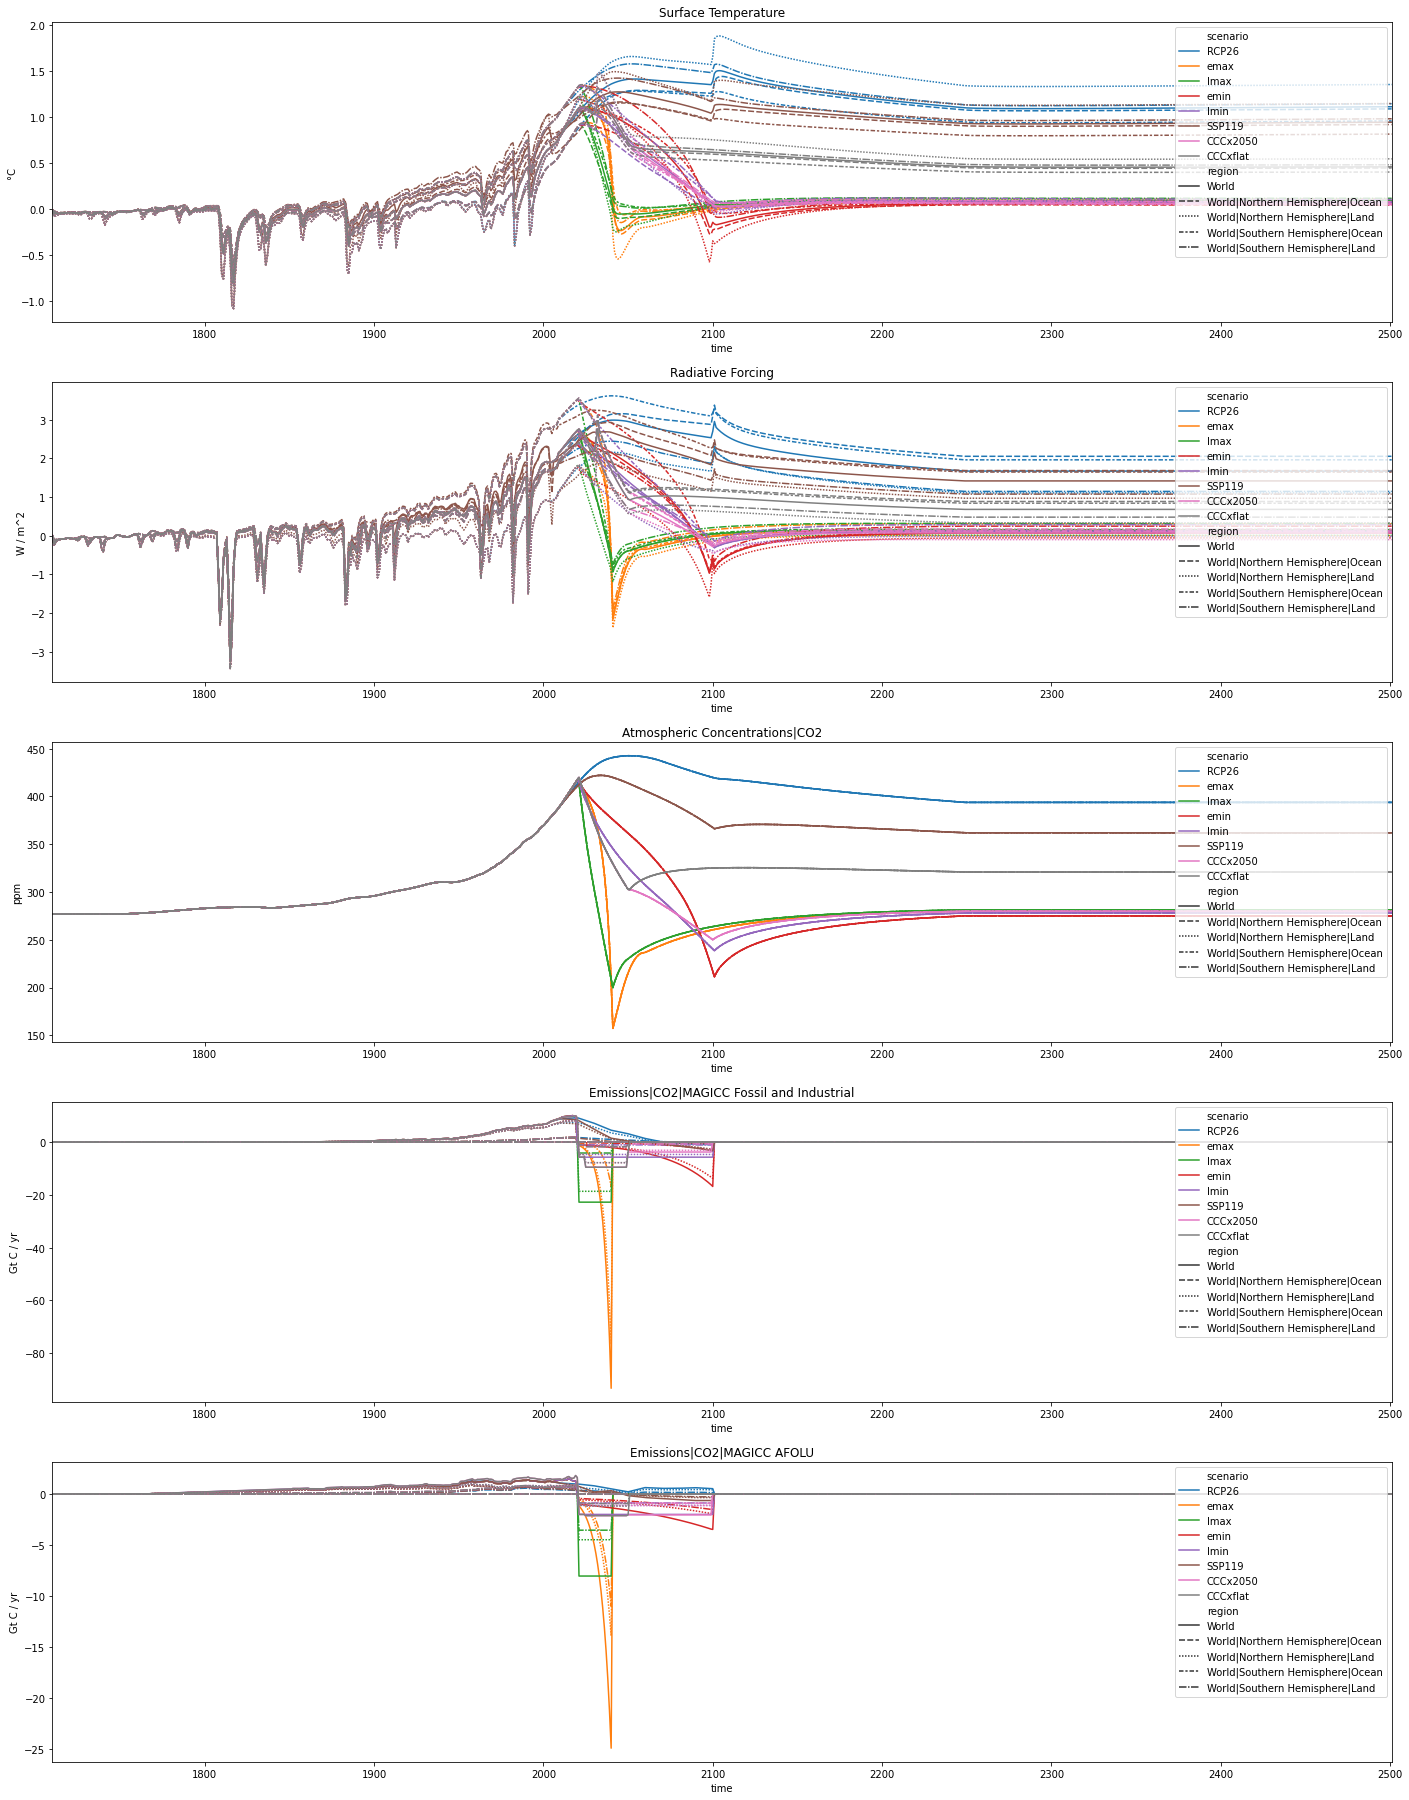

In [26]:
res = ""
%time res = pymagicc.run(rcp26, **magcfg)  #need to create res of type MAGICCData
res = meanbln(rcp26,res,**magcfg)

# Toggle to run and graph all the experiments
declines.append(CCCxflat)
#declines.append(CCCx2050)

for scen in declines:
    tmprs = pymagicc.run(scen, **magcfg)
    res = res.append(meanbln(scen, tmprs, **magcfg))
    
#for cccsn in CCCxflat,CCCx2050:
#tmprs = pymagicc.run(CCCx2050, **magcfg)
#res = res.append(meanbln(CCCx2050,tmprs,**magcfg))

#print(CCC_df.loc[emsf, datetime(2005,1,1,0):datetime(2020,1,1,0)].sum().max())

fig, axes = plt.subplots((len(vars)), 1, figsize=(24, 32))
for n, var in enumerate(vars):
    res.filter(variable=var).lineplot(hue="scenario", style="region", ax=axes[n])
    ylab = res.filter(variable=var)["unit"].iloc[[0]].all()
    if ylab == 'K':
        ylab = '°C'
    axes[n].set_ylabel(ylab)
    axes[n].set_title(var)                        
    axes[n].set_xlim(x)
    axes[n].legend(loc='upper right')

# Diagnostic Output

In [27]:
for dt in 2020,2050,2100,2500:
    for var in vars,ems_ff:
        print(res.filter(variable = var,
                         region='World').timeseries().loc[:,datetime(dt,1,1)])
    for cgas in ems_ff,ems_luc:
        print("Cumulative CO₂ 1750 to", dt)
        print(res.filter(variable=cgas,
                         region='World').timeseries().loc[:,datetime(1750,1,1):datetime(dt,1,1)].sum(axis=1))
        print("Max CO₂ 1750 to", dt)
        print(res.filter(variable=cgas,
                         region='World').timeseries().loc[:,datetime(1750,1,1):datetime(dt,1,1)].max(axis=1))

#res.filter(variable = "Atmospheric Concentrations|CO2",region="World").timeseries().loc[:,datetime(2045,1,1):datetime(2052,1,1)] >= 300
#res.filter(variable = "Atmospheric Concentrations|CO2",region="World").timeseries().loc[:,datetime(1909,1,1):datetime(1920,1,1)] >= 299


climate_model  model  region  scenario  todo          unit       variable                                  
MAGICC6        IMAGE  World   RCP26     not_relevant  ppm        Atmospheric Concentrations|CO2                413.112720
                                                      W / m^2    Radiative Forcing                               2.611514
                                                      K          Surface Temperature                             1.038597
                                                      Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial      9.287700
                                                                 Emissions|CO2|MAGICC AFOLU                      0.972800
               CDRex  World   emax      not_relevant  ppm        Atmospheric Concentrations|CO2                417.305550
                                                      W / m^2    Radiative Forcing                               2.717597
                                      

climate_model  model  region  scenario  todo          unit       variable                                  
MAGICC6        IMAGE  World   RCP26     not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    3.1856
               CDRex  World   emax      not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    0.0000
                              lmax      not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    0.0000
                              emin      not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial   -2.8776
                              lmin      not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial   -5.6886
               IMAGE  World   SSP119    not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    0.4394
               CDRex  World   CCCx2050  not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial   -3.7400
                              CCCxflat  not_relevant  Gt C / yr  E

climate_model  model  region  scenario  todo          unit       variable                                  
MAGICC6        IMAGE  World   RCP26     not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    641.691459
               CDRex  World   emax      not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial     -0.000106
                              lmax      not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial     -0.000006
                              emin      not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial     -0.000006
                              lmin      not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial     -0.000006
               IMAGE  World   SSP119    not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    494.706739
               CDRex  World   CCCx2050  not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial     15.238194
                              CCCxflat

climate_model  model  region  scenario  todo          unit       variable                                  
MAGICC6        IMAGE  World   RCP26     not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial     9.2877
               CDRex  World   emax      not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    10.0727
                              lmax      not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    10.0727
                              emin      not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    10.0727
                              lmin      not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial    10.0727
               IMAGE  World   SSP119    not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial     8.9321
               CDRex  World   CCCx2050  not_relevant  Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial     9.9500
                              CCCxflat  not_relevant  Gt C 

The default parameters are the ones that were used to produce the RCP GHG concentrations (see also http://live.magicc.org/). Of course it's easy to change them.

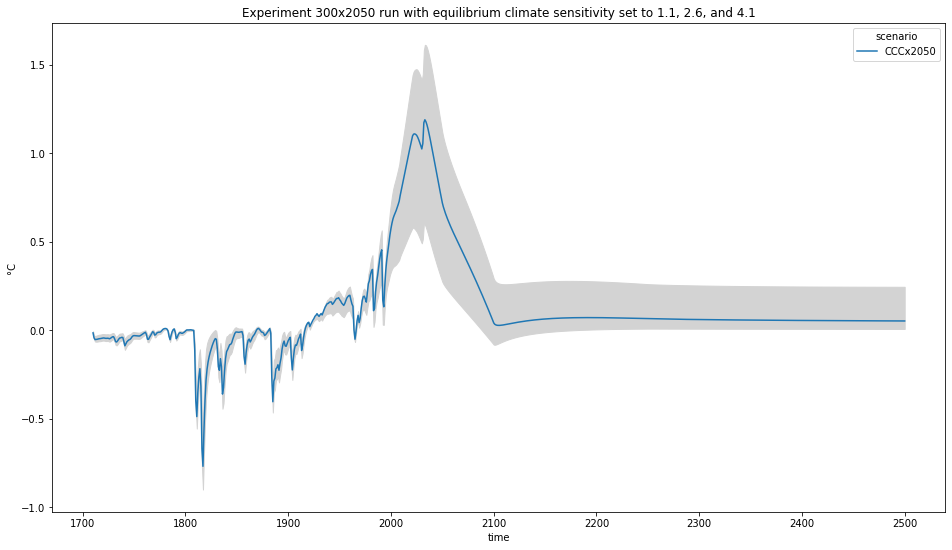

In [28]:
scenario = CCCx2050
runs = {"default":sitv, 
        "low":lsitv,
        "high":hsitv}
runsdf = {}
mcfg = magcfg.copy()

for rn in runs:
    mcfg['core_climatesensitivity'] = runs[rn]
    newrn = pymagicc.run(scenario, **mcfg)
    runsdf[rn] = meanbln(scenario, newrn, **mcfg)

filtering = {"region": "World", "variable": "Surface Temperature", 
             "year": range(1700, magcfg["endyear"])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
runsdf['default'].filter(**filtering).line_plot(x="time", ax=ax)
plt.fill_between(
    runsdf['default'].filter(**filtering)['time'],
    runsdf['low'].filter(**filtering).timeseries().values.squeeze(),
    runsdf['high'].filter(**filtering).timeseries().values.squeeze(),
    color="lightgray"
)
plt.title(
    (f"Experiment 300x2050 run with equilibrium climate sensitivity set to {lsitv}, {sitv}, and {hsitv}")
)
plt.ylabel("°C");